# Load in and view the data

In [110]:
import pandas as pd
import os
import numpy as np
import time
def load_timeseries_data(directory:str):
    # Load all of the  data into a single dataframe from a given directory by walking through the directory
    # and loading each file into a dataframe
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                series = pd.read_csv(os.path.join(root, file),header=0, index_col=0)
                # Turn series to np array
                series = series.to_numpy().flatten()
                data += [series]
    return data

In [77]:
experimental_data = load_timeseries_data('signal_data/experimental')
reference_data = load_timeseries_data('signal_data/reference')

In [80]:
len(experimental_data[0])

50

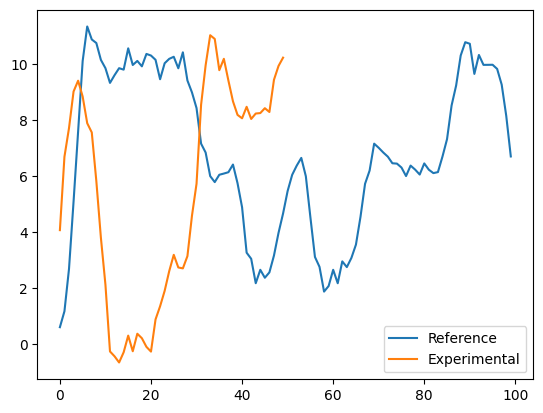

In [82]:
# View the first series as a graph of both the experimental and refrence data
import matplotlib.pyplot as plt
plt.plot(reference_data[0], label='Reference')
plt.plot(experimental_data[0], label='Experimental')
plt.legend()

# Using Distance Time Warping

In [141]:
window_size = 50

# Generate sliding windows for each reference signal
reference_windows = []
timestamps = []
series_indices = []

for series_idx, series in enumerate(reference_data):
    for i in range(len(series) - window_size):
        window = series[i:i+window_size]
        timestamp = i  # Example timestamp, replace with actual timestamp if available
        timestamps.append(timestamp)
        series_indices.append(series_idx)
        reference_windows.append((window, len(timestamps) - 1))


Time to find best match: 0.0 seconds


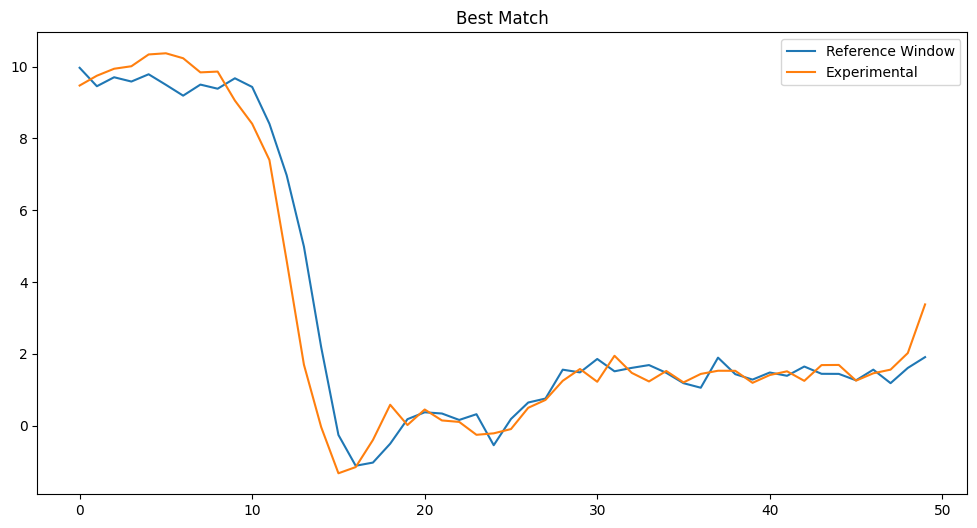

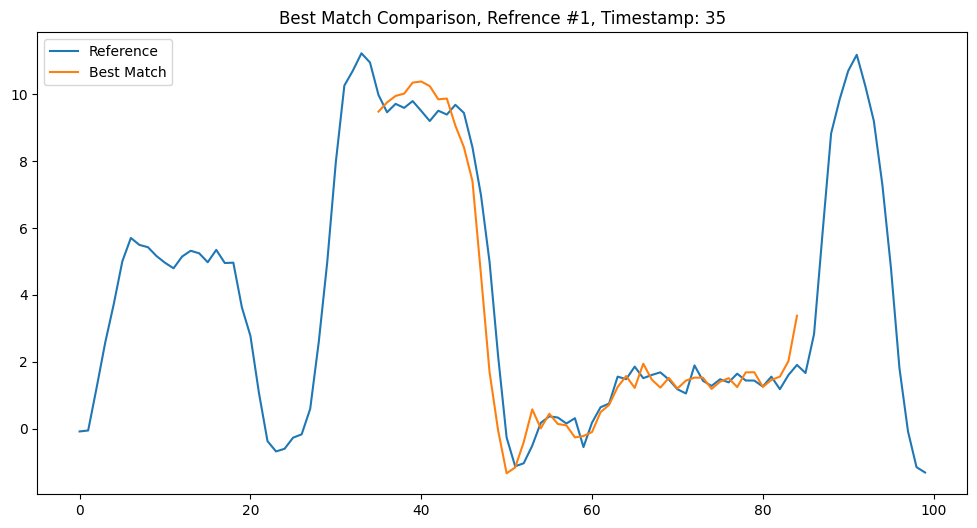

In [192]:
from dtaidistance import dtw

def find_best_match(signal: np.array, reference_windows: list):
    lowest_distance = float('inf')
    lowest_index = None
    for idx, (window, info_idx) in enumerate(reference_windows):

        # Calculate DTW distance between the experimental signal and the reference window
        distance = dtw.distance_fast(signal, window, window=2)

        # Find the lowest distance and the index of the lowest distance
        if distance < lowest_distance:
            lowest_distance = distance
            lowest_index = idx

    return lowest_index, lowest_distance

def plot_results_of_match(signal, best_window, best_timestamp, best_initial_series, best_series_idx):
    plt.figure(figsize=(12, 6))
    plt.plot(best_window, label='Reference Window')
    plt.plot(signal, label='Experimental')
    plt.legend()
    plt.title('Best Match')
    plt.show()

    # Show which initial signal was the best match
    plt.figure(figsize=(12, 6))
    plt.plot(best_initial_series, label='Reference')
    plt.plot(range(best_timestamp, best_timestamp + len(best_window)), signal, label='Best Match')
    # Start the best match at the timestamp
    plt.legend()
    plt.title(f'Best Match Comparison, Refrence #{best_series_idx}, Timestamp: {best_timestamp}')
    plt.show()

first_signal = np.array(experimental_data[2]).flatten()
# Track the time to find the best match
start = time.time()
best_index, lowest_distance = find_best_match(first_signal, reference_windows)
best_window, info_idx = reference_windows[best_index]
best_timestamp = timestamps[info_idx]
best_series_idx = series_indices[info_idx]
end = time.time()
print(f'Time to find best match: {end - start} seconds')
# Retrieve the best match information

plot_results_of_match(first_signal, best_window, best_timestamp, reference_data[best_series_idx], best_series_idx)



In [193]:
# Calculate the average time to find the best match for all experimental signals
distances = []
start = time.time()
for signal in experimental_data:
    _, lowest_distance = find_best_match(signal, reference_windows)
    distances.append(lowest_distance)
end = time.time()
print(f'Average time to find best match: {(end - start) / len(experimental_data)} seconds')
print(f'Average distance: {np.mean(distances)}')

Average time to find best match: 0.000787818431854248 seconds
Average distance: 5.380987912542851


# Using ML

Time to find best match: 0.004999876022338867 seconds


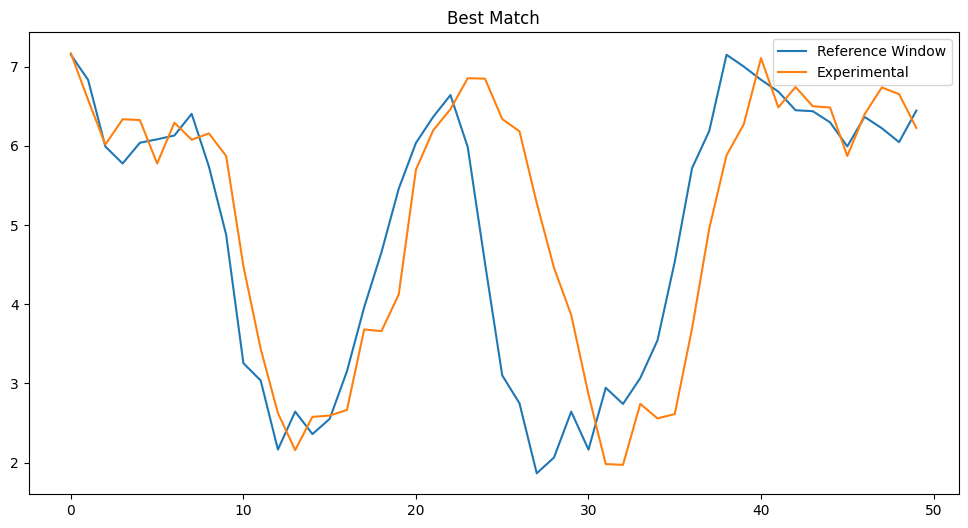

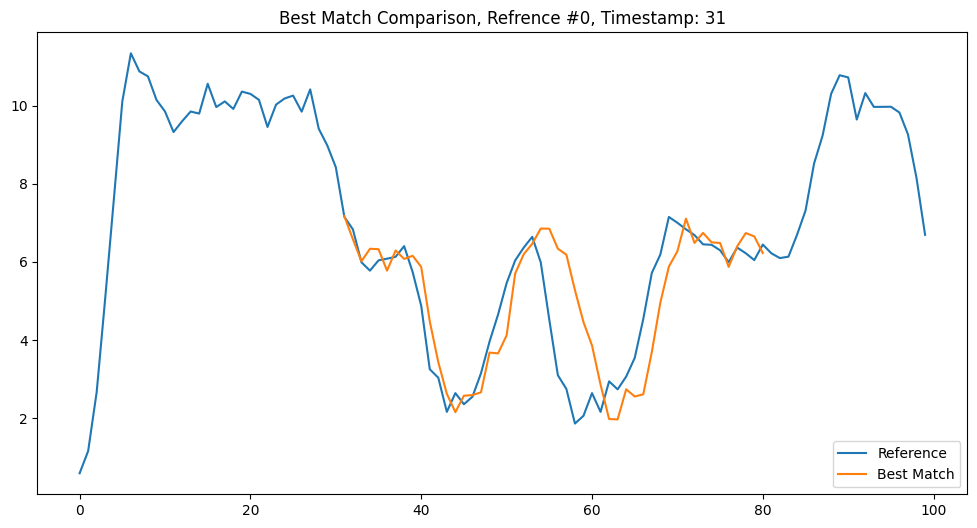

In [186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from scipy.fftpack import fft

# Function to extract features
def extract_features(signal):
    # Use FFT for frequency-domain features
    fft_features = np.abs(fft(signal))[:len(signal)//2]
    # Extract statistical features
    return np.concatenate([
        [np.mean(signal), np.std(signal), np.min(signal), np.max(signal)],
        fft_features
    ])

def create_model(reference_windows):
    # Create feature matrix for reference windows
    X = np.array([extract_features(window) for window, _ in reference_windows])
    y = np.array([idx for _, idx in reference_windows])

    # Split into train and test for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Train a Random Forest classifier
    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
    model.fit(X_train, y_train)
    return model

def calc_best_from_top_3(model, new_signal, reference_windows):
    # Predict probabilities for a new signal
    new_signal_features = extract_features(new_signal).reshape(1, -1)
    proba = model.predict_proba(new_signal_features).flatten()

    # Get indices of the top 3 matches
    top_3_indices = proba.argsort()[-3:][::-1]

    # Compute DTW distance for the top 3 matches
    dtw_results = []
    for idx in top_3_indices:
        window, _ = reference_windows[idx]
        distance = dtw.distance_fast(new_signal, window)
        dtw_results.append((distance, idx))

    # Select the best match based on DTW distance
    dtw_results.sort()  # Sort by distance
    best_dtw_distance, best_dtw_index = dtw_results[0]

    # Retrieve corresponding info
    best_window, info_idx = reference_windows[best_dtw_index]
    best_timestamp = timestamps[info_idx]
    best_series_idx = series_indices[info_idx]
    
    return best_window, best_timestamp, best_series_idx, best_dtw_distance
    

# Create a model
model = create_model(reference_windows)

# Track the time to find the best match
new_signal = np.array(experimental_data[1]).flatten()
start = time.time()
best_window, best_timestamp, best_series_idx, best_dtw_distance = calc_best_from_top_3(model, new_signal, reference_windows)
end = time.time()
print(f'Time to find best match: {end - start} seconds')


plot_results_of_match(new_signal, best_window, best_timestamp, reference_data[best_series_idx], best_series_idx)


In [191]:
# Calculate the average time to find the best match for all experimental signals
distances = []
start = time.time()
for signal in experimental_data:
    _, _, _, best_dtw_distance = calc_best_from_top_3(model, signal, reference_windows)
    distances.append(best_dtw_distance)
end = time.time()
print(f'Average time to find best match: {(end - start) / len(experimental_data)} seconds')
print(f'Average distance: {np.mean(distances)}')

Average time to find best match: 0.003951507806777954 seconds
Average distance: 8.84578388395071
